In [202]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# Lightly adapted from https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb

# Automatically generating object masks with SAM

Since SAM 2 can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image.

The class `SAM2AutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything-2/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Environment Set-up

If running locally using jupyter, first install `SAM 2` in your environment using the installation instructions in the repository.

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'. Note that it's recommended to use **A100 or L4 GPUs when running in Colab** (T4 GPUs might also work, but could be slow and might run out of memory in some cases).

In [203]:
using_colab = False
target_image_path = "/app/sam2/notebooks/images/dogcat.png"
save_masks_dir = "/app/sam2/notebooks/masks/dogcat"


In [204]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything-2.git'

    !mkdir -p images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything-2/main/notebooks/images/cars.jpg

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt

## Set-up

In [205]:
import os

# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [206]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [207]:
np.random.seed(3)


def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x["area"]), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones(
        (
            sorted_anns[0]["segmentation"].shape[0],
            sorted_anns[0]["segmentation"].shape[1],
            4,
        )
    )
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann["segmentation"]
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
        if borders:
            import cv2

            contours, _ = cv2.findContours(
                m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
            )
            # Try to smooth contours
            contours = [
                cv2.approxPolyDP(contour, epsilon=0.01, closed=True)
                for contour in contours
            ]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1)

    ax.imshow(img)

## Example image

In [208]:
image = Image.open(target_image_path)
image = np.array(image.convert("RGB"))

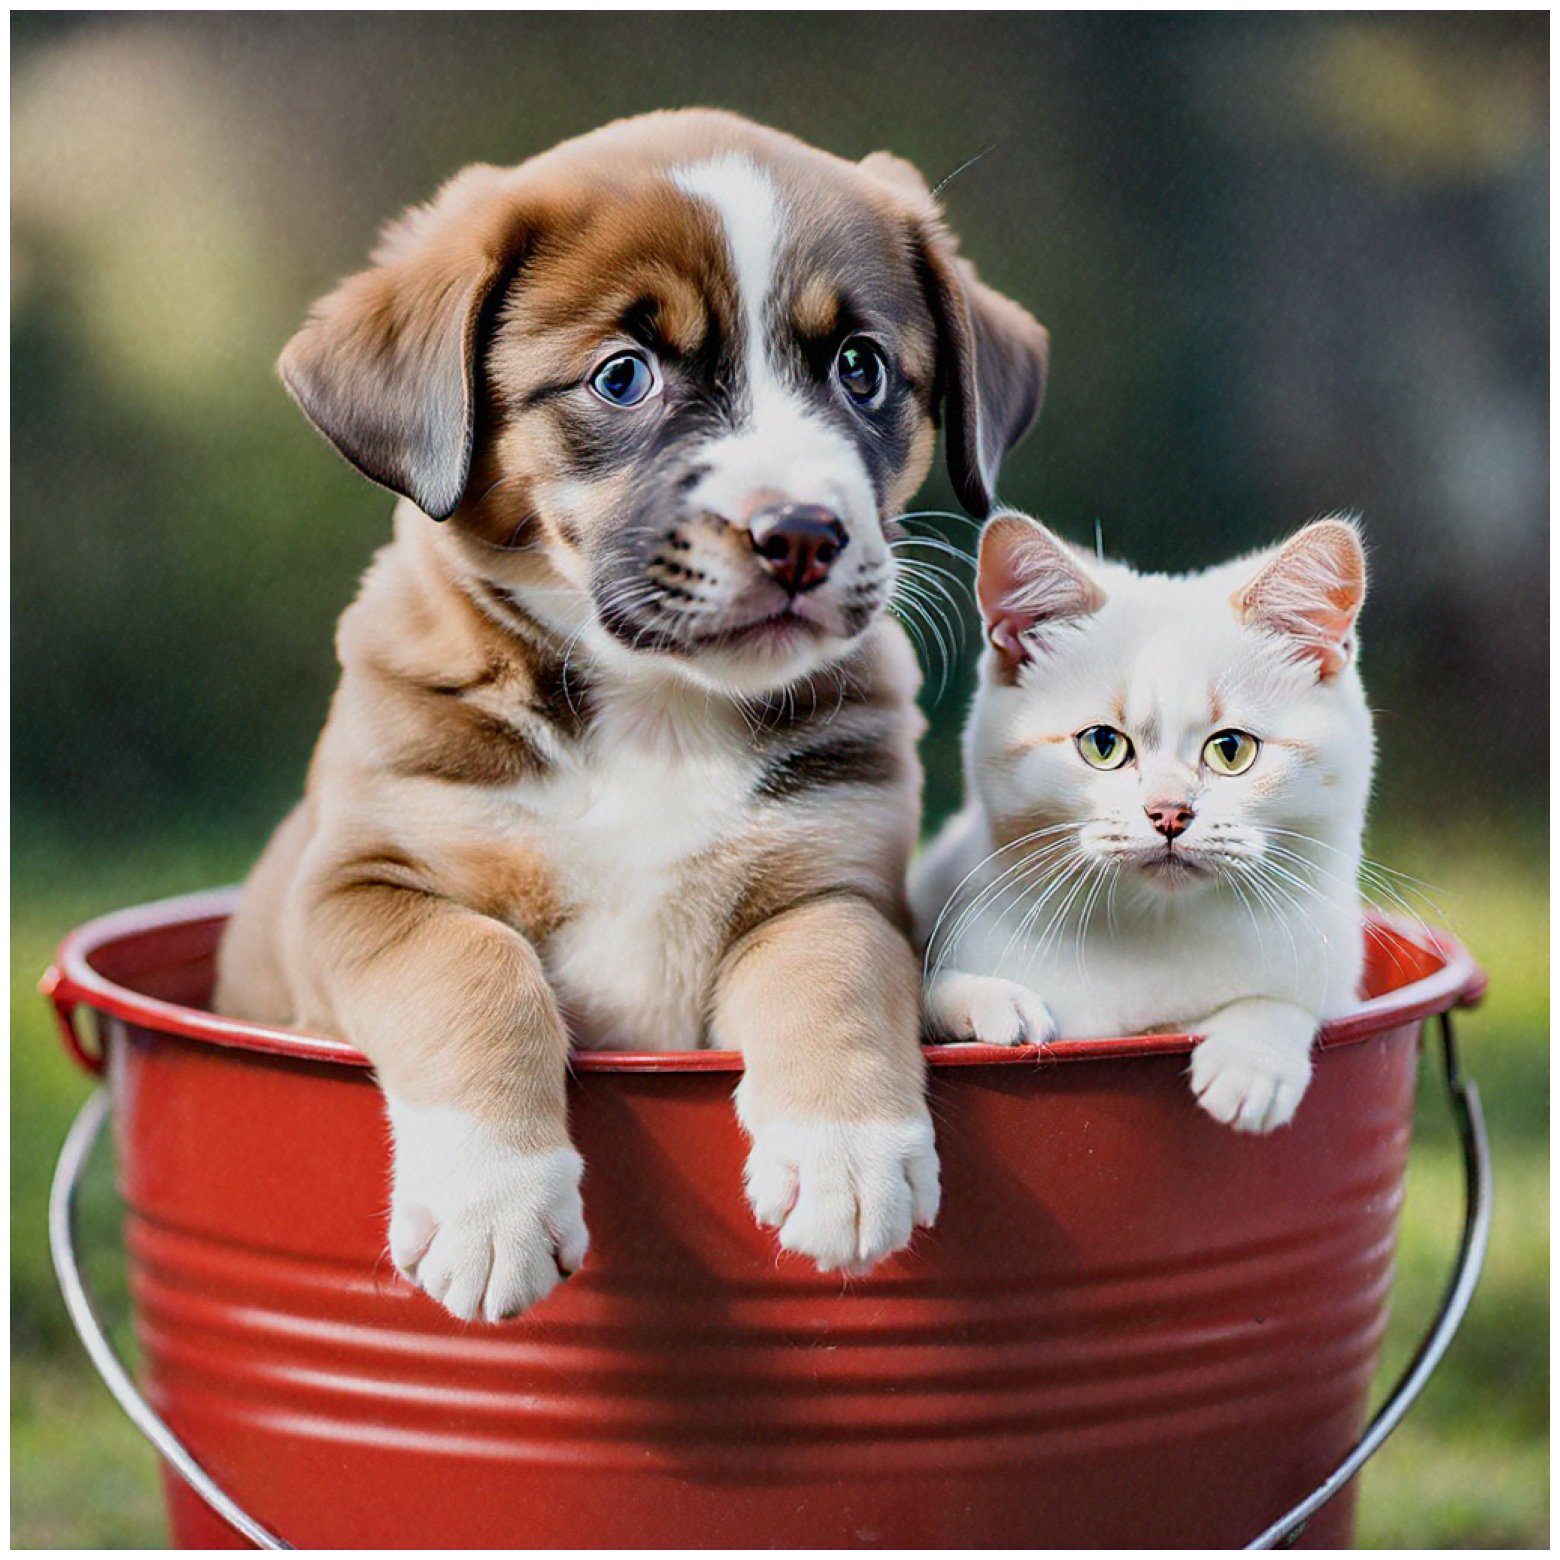

In [209]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
plt.axis("off")
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a version of SAM 2 to the `SAM2AutomaticMaskGenerator` class. Set the path below to the SAM 2 checkpoint.

In [210]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2)

To generate masks, just run `generate` on an image.

In [211]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [212]:
print(len(masks))
print(masks[0].keys())

22
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Show all the masks overlayed on the image.

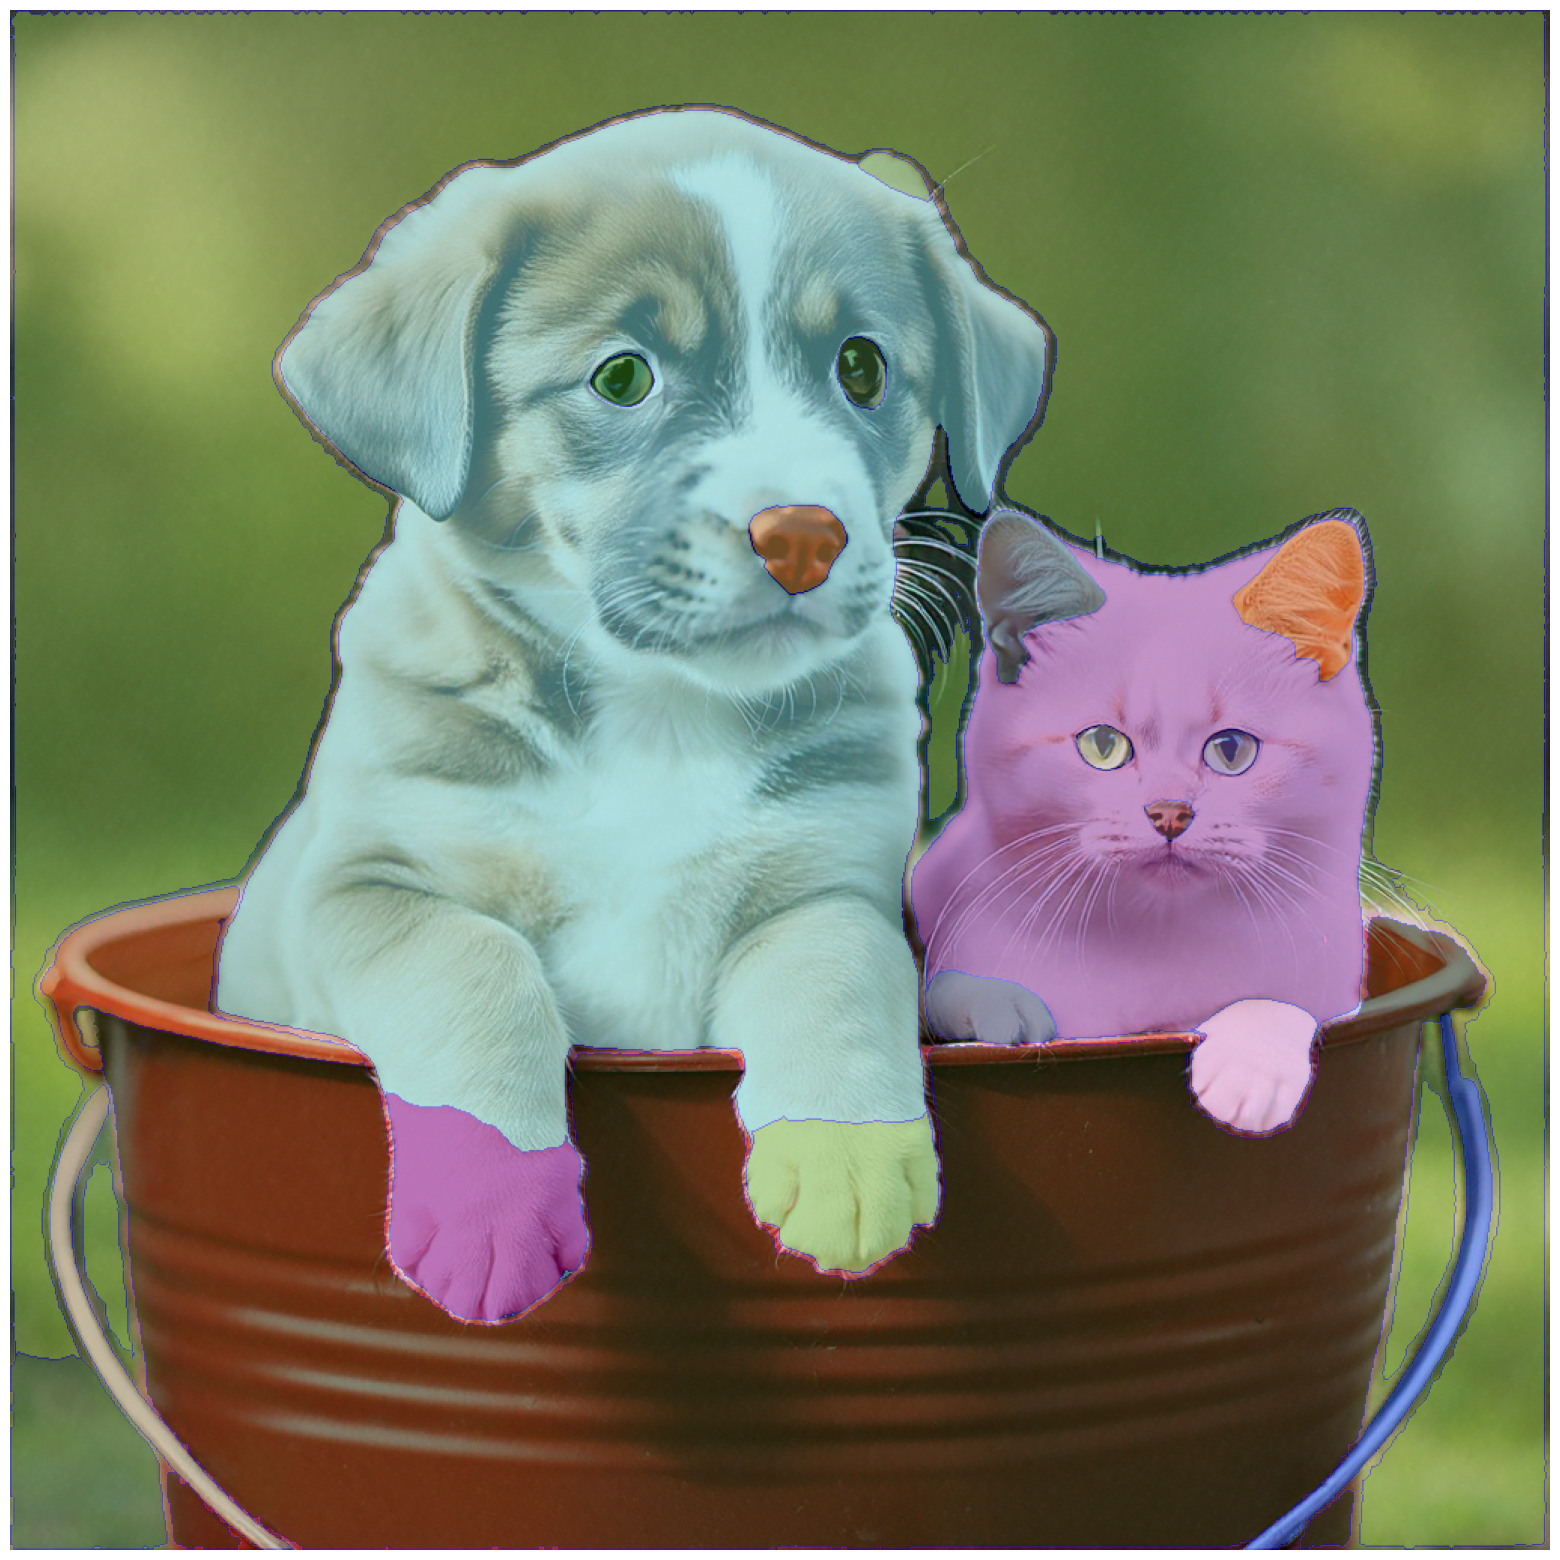

In [213]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis("off")
plt.show()

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [285]:
# mask_generator_2 = SAM2AutomaticMaskGenerator(
#     model=sam2,
#     points_per_side=64,
#     points_per_batch=128,
#     pred_iou_thresh=0.7,
#     stability_score_thresh=0.92,
#     stability_score_offset=0.7,
#     crop_n_layers=1,
#     box_nms_thresh=0.7,
#     crop_n_points_downscale_factor=2,
#     min_mask_region_area=25.0,
#     use_m2m=True,
# )

In [286]:
masks2 = mask_generator_2.generate(image)

OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB. GPU 0 has a total capacity of 23.68 GiB of which 153.44 MiB is free. Process 2361 has 258.00 MiB memory in use. Process 1622670 has 12.90 GiB memory in use. Process 1690379 has 9.33 GiB memory in use. Of the allocated memory 7.69 GiB is allocated by PyTorch, and 1.32 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [216]:
# plt.figure(figsize=(20, 20))
# plt.imshow(image)
# show_anns(masks2)
# plt.axis("off")
# plt.show()

In [ ]:
mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2,
    # pred_iou_thresh=0.97,
    # box_nms_thresh=0.5,
)

masks2 = mask_generator_2.generate(image)

plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks2)
plt.axis("off")
plt.show()

In [288]:
for mask in masks2:
    print(mask["predicted_iou"])
    # print(mask["stability_score"])

0.99609375
0.9921875
0.9921875
0.98828125
0.98046875
0.9765625
0.9765625
0.9765625
0.96484375
0.96484375
0.95703125
0.95703125
0.953125
0.953125
0.953125
0.94921875
0.9453125
0.92578125
0.91796875
0.9140625
0.90625
0.87109375


Masks type: <class 'list'>
Number of masks: 22
First mask type: <class 'dict'>
Keys in first mask: dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
Image saved to /app/sam2/notebooks/masks/dogcat/masks_.png


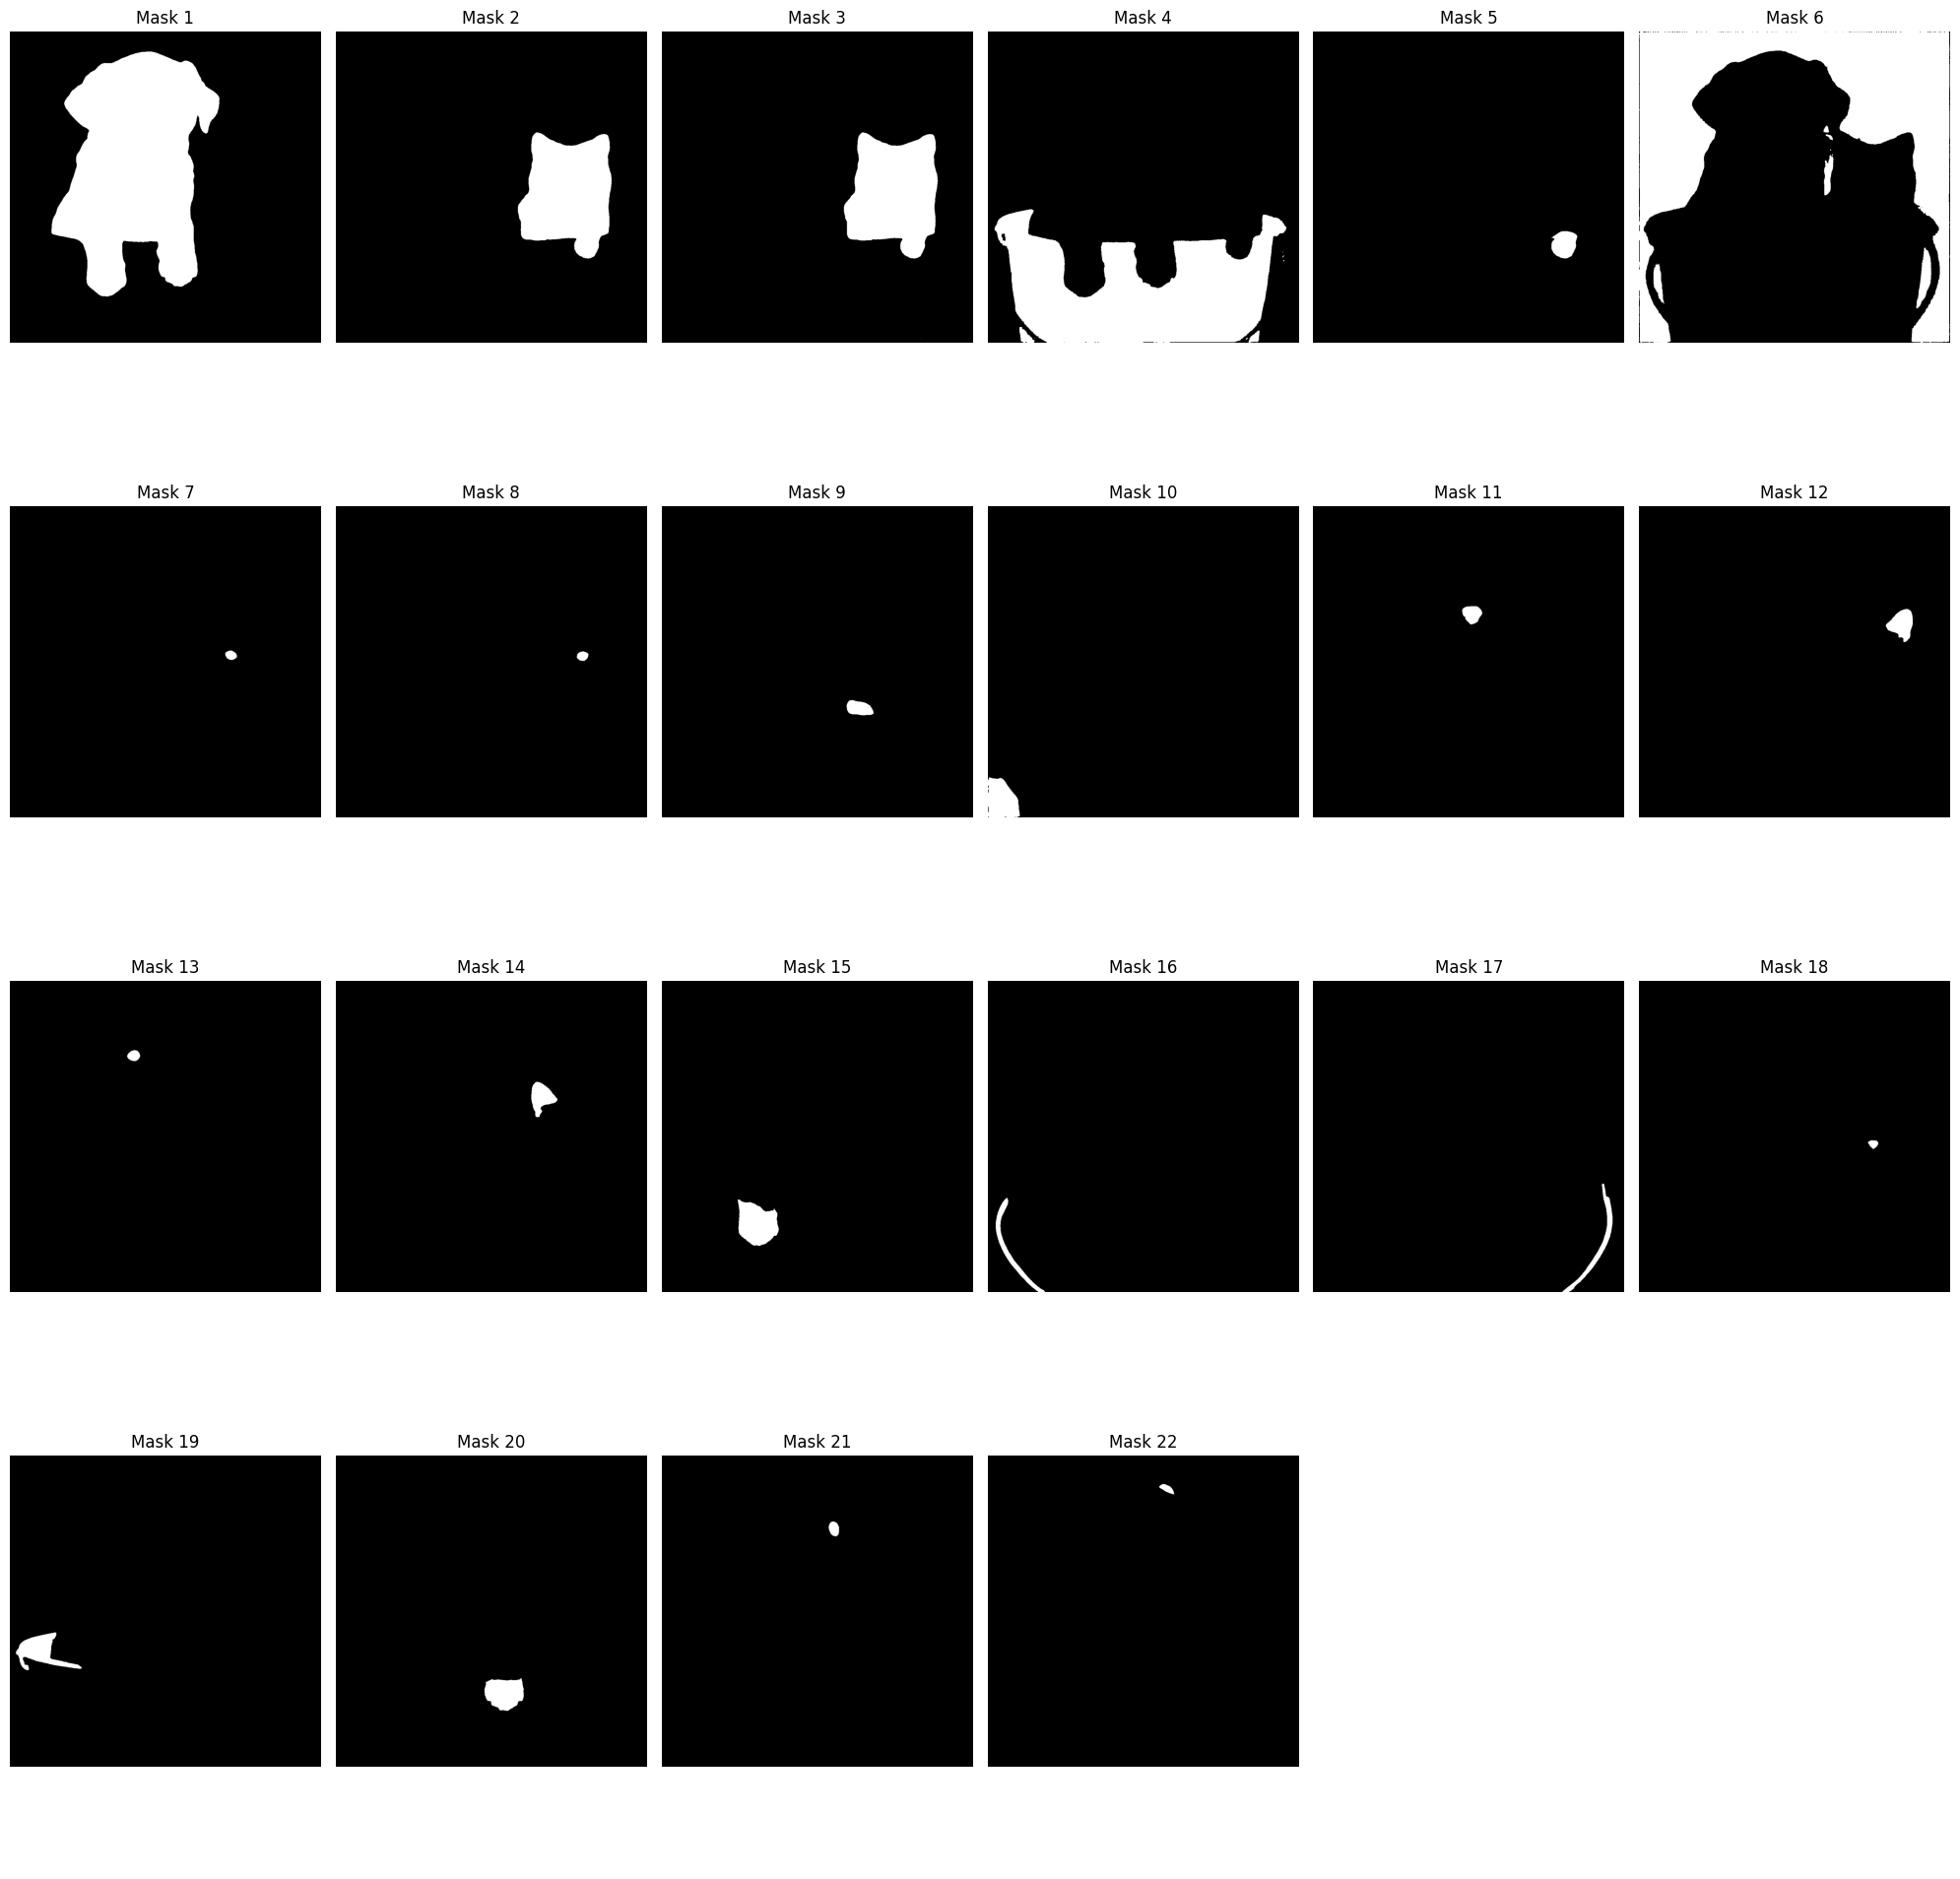

In [289]:
import math


def display_masks_grid(masks, max_masks=None, save_path=None):
    if max_masks is not None:
        masks = masks[:max_masks]

    num_masks = len(masks)
    rows = int(math.sqrt(num_masks))
    cols = math.ceil(num_masks / rows)

    fig, axs = plt.subplots(rows, cols, figsize=(20, 20))
    # fig.suptitle("Detected Masks", fontsize=16)

    for i, mask in enumerate(masks):
        row = i // cols
        col = i % cols
        ax = axs[row, col] if rows > 1 else axs[col]

        # マスクデータの形式を確認し、適切に処理する
        if isinstance(mask, dict) and "segmentation" in mask:
            mask_data = mask["segmentation"]
        else:
            print(f"Unexpected mask format for mask {i+1}: {type(mask)}")
            continue

        # マスクデータが2次元でない場合は形状を表示して次のマスクに進む
        if mask_data.ndim != 2:
            print(f"Unexpected shape for mask {i+1}: {mask_data.shape}")
            continue

        ax.imshow(mask_data, cmap="gray")
        ax.axis("off")
        ax.set_title(f"Mask {i+1}")

    # 余分なサブプロットを非表示にする
    for i in range(num_masks, rows * cols):
        row = i // cols
        col = i % cols
        ax = axs[row, col] if rows > 1 else axs[col]
        ax.axis("off")

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Image saved to {save_path}")
    plt.show()


# 使用例
print("Masks type:", type(masks2))
print("Number of masks:", len(masks2))
if len(masks2) > 0:
    print("First mask type:", type(masks2[0]))
    if isinstance(masks2[0], dict):
        print("Keys in first mask:", masks2[0].keys())
    elif isinstance(masks2[0], np.ndarray):
        print("Shape of first mask:", masks2[0].shape)

display_masks_grid(
    masks2, max_masks=25, save_path=f"{save_masks_dir}/masks_.png"
)  # 最大25個のマスクを表示

In [280]:
import numpy as np
from PIL import Image


def save_specific_mask(masks, mask_number, save_path):
    if mask_number < 1 or mask_number > len(masks):
        print(
            f"Invalid mask number. Please choose a number between 1 and {len(masks)}."
        )
        return

    mask = masks[mask_number - 1]  # リストは0から始まるので、1を引く

    # マスクデータの形式を確認し、適切に処理する
    if isinstance(mask, dict) and "segmentation" in mask:
        mask_data = mask["segmentation"]
        if isinstance(mask_data, np.ndarray):
            pass  # すでにnumpy配列の場合は何もしない
        else:
            print(
                f"Unexpected segmentation format for mask {mask_number}: {type(mask_data)}"
            )
            return
    else:
        print(f"Unexpected mask format for mask {mask_number}: {type(mask)}")
        return

    # マスクデータが2次元でない場合はエラーメッセージを表示して終了
    if mask_data.ndim != 2:
        print(f"Unexpected shape for mask {mask_number}: {mask_data.shape}")
        return

    # データ型に応じて適切に処理する
    if mask_data.dtype == bool:
        mask_data = ~mask_data  # ブール値を反転(Amazon Titan専用)
        mask_data = mask_data.astype(np.uint8) * 255
    else:
        print(f"Unexpected dtype for mask {mask_number}: {mask_data.dtype}")
        return

    # NumPy配列をPIL Imageに変換
    image = Image.fromarray(mask_data, mode="L")  # 'L'はグレースケールモード

    # 画像を保存
    image.save(save_path)
    print(f"Mask {mask_number} saved to {save_path}")

    # マスクの情報を表示（デバッグ用）
    print(
        f"Mask {mask_number} info: shape={mask_data.shape}, dtype={mask_data.dtype}, min={np.min(mask_data)}, max={np.max(mask_data)}"
    )


# 使用例
# 5番目のマスクを保存する場合
target_num = 3
save_specific_mask(
    masks2, mask_number=target_num, save_path=f"{save_masks_dir}/mask_{target_num}.png"
)

# # 複数のマスクを保存する場合
# mask_numbers = [1, 3, 5, 7]
# for num in mask_numbers:
#     save_specific_mask(masks2, num, f"mask_{num}_pil.png")

Mask 3 saved to /app/sam2/notebooks/masks/dogcat/mask_3.png
Mask 3 info: shape=(1024, 1024), dtype=uint8, min=0, max=255


---

In [266]:
np.random.seed(3)

def show_anns2(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x["area"]), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    # 背景を黒で初期化（黒背景で、マスクを白黒で際立たせる）
    img = np.ones(
        (
            sorted_anns[0]["segmentation"].shape[0],
            sorted_anns[0]["segmentation"].shape[1],
            4,  # 4チャンネル（RGBA）
        )
    )
    img[:, :, 3] = 1  # 完全に不透明な画像

    for ann in sorted_anns:
        m = ann["segmentation"]
        color_mask = np.concatenate([np.random.random(3), [1.0]])
        img[m] = color_mask

        if borders:
            import cv2
            contours, _ = cv2.findContours(
                m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
            )
            # 輪郭を滑らかにする
            contours = [
                cv2.approxPolyDP(contour, epsilon=0.01, closed=True)
                for contour in contours
            ]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1)  # 境界線は青色、不透明に描画

    print(img.shape)
    ax.imshow(img)  # マスクだけを表示


In [267]:
mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2,
    pred_iou_thresh=0.90,
    box_nms_thresh=0.5,
)

masks2 = mask_generator_2.generate(image)


(1024, 1024, 4)


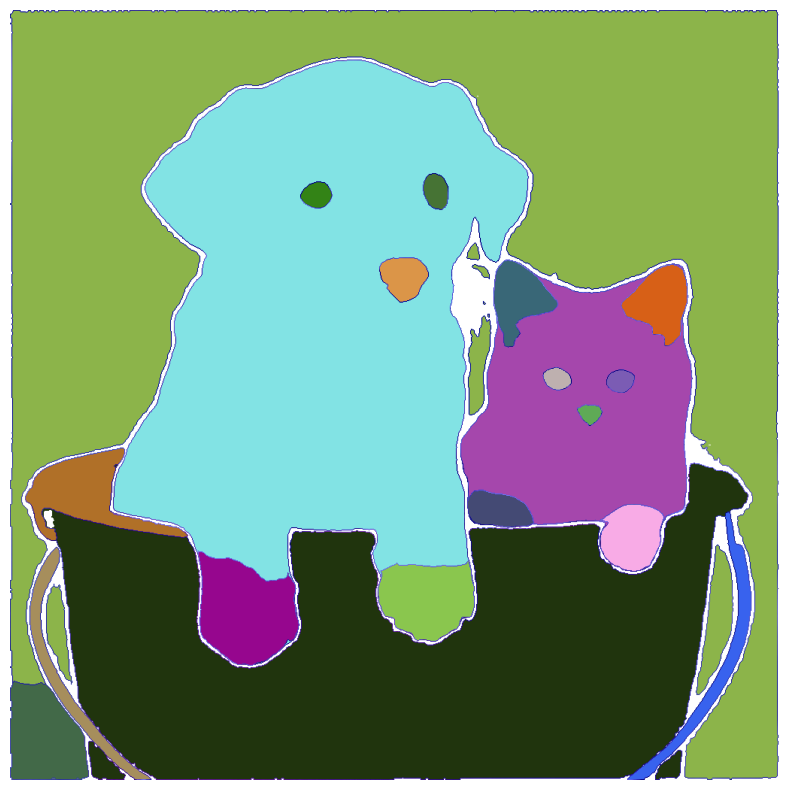

In [268]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_anns2(masks2)  # マスクだけを表示
plt.axis("off")
plt.savefig(f"dogcat_segmentation_mask.png", bbox_inches='tight', pad_inches=0)
plt.show()

Mask 1 saved to /app/sam2/notebooks/masks/dogcat/mask_1.png
Mask 1 info: shape=(1024, 1024), dtype=uint8, min=0, max=255


In [224]:
# import boto3
# import base64
# import json
# import io
# from botocore.client import BaseClient
# import pprint

# def init_bedrock_client() -> BaseClient:
#     """
#     Initialize the Bedrock client.
#     Returns:
#         BaseClient: The Bedrock client.
#     """
#     return boto3.client(service_name="bedrock-runtime", region_name="us-west-2")


# def read_image_as_base64(image_path: str) -> str:
#     with open(image_path, "rb") as image_file:
#         image_bytes = image_file.read()
#     return base64.b64encode(image_bytes).decode("utf-8")


# def make_inpainting_body(
#     prompt: str,
#     negative_prompt: str,
#     input_image: str,
#     mask_image: str = None,
#     mask_prompt: str = None,
# ) -> str:
#     if mask_image:
#         mask_data = {"maskImage": mask_image}
#     elif mask_prompt:
#         mask_data = {"maskPrompt": mask_prompt}
#     else:
#         raise ValueError("Either mask_image or mask_prompt must be provided")

#     body = {
#         "taskType": "INPAINTING",
#         "inPaintingParams": {
#             # "text": prompt,
#             "negativeText": negative_prompt,
#             "image": input_image,
#             **mask_data,
#         },
#         "imageGenerationConfig": {
#             "numberOfImages": 1,
#             "height": 1024,
#             "width": 1024,
#             "cfgScale": 10.0,
#             "seed": 0,
#         },
#     }
#     return json.dumps(body)


# def generate_image(client, model_id, body):
#     """
#     Generate an image using Amazon Titan Image Generator G1 model on demand.
#     Args:
#         model_id (str): The model ID to use.
#         body (str) : The request body to use.
#     Returns:
#         image_bytes (bytes): The image generated by the model.
#     """

#     accept = "application/json"
#     content_type = "application/json"

#     response = client.invoke_model(
#         body=body, modelId=model_id, accept=accept, contentType=content_type
#     )
#     # print(response)
#     print(type(response))
#     # pprint.pprint(response)
#     response_body = json.loads(response.get("body").read())
#     print(type(response_body))
#     # print(response_body)

#     base64_image = response_body.get("images")[0]
#     print("#"*100)
#     print(len(response_body.get("images")))
#     print("#"*100)
#     print("#"*100)
#     print("#"*100)
#     base64_bytes = base64_image.encode("utf-8")
#     image_bytes = base64.b64decode(base64_bytes)

#     print(type(image_bytes))
#     # pprint.pprint(response_body)

#     return image_bytes


# model_id = "amazon.titan-image-generator-v2:0"
# prompt = "A black cat"
# negative_prompt = "bad quality, low res, noise"
# input_image_path = target_image_path
# mask_image_path = f"{save_masks_dir}/mask_1.png"

# client = init_bedrock_client()
# input_image = read_image_as_base64(input_image_path)
# mask_image = read_image_as_base64(mask_image_path)
# mask_prompt = "A chite cat"
# # body = make_inpainting_body(prompt, negative_prompt, input_image, mask_image=mask_image)
# body = make_inpainting_body(prompt, negative_prompt, input_image, mask_prompt=mask_prompt)
# image_bytes = generate_image(client, model_id, body)
# image = Image.open(io.BytesIO(image_bytes))
# image.show()